In [ ]:
This uses the "Cube Reprojection and Signal Masking Tutorial"

In [3]:
# Make methyl cyanide temperature maps using a template molecule for masking
from astroquery.splatalogue import Splatalogue
from spectral_cube import SpectralCube
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as nd
from dask.diagnostics import ProgressBar

In [10]:
def get_noise_map(cube_noise):
    cube_sclip = cube_noise.sigma_clip_spectrally(3) # Clip values above 3-sigma 
    mad_std_spectrum_sclip = cube_sclip.mad_std(axis=(1, 2))
    plt.plot(mad_std_spectrum_sclip.spectral_axis.value, mad_std_spectrum_sclip.value, 
             drawstyle='steps-mid')
    plt.xlabel('Velocity (km/s)')
    plt.ylabel(r' Noise standard deviation $\sigma$ (K)')
#     plt.ylim([0., 0.30]) # Best to extend the range to 0.
#     plt.axhline(0.25, linestyle='--', color='k', linewidth=3, label='A priori noise expectation')
#     plt.legend(frameon=True)
    mad_std_map_sclip = cube_sclip.mad_std(axis=0) # Calculate sigma along the spectral dimension
    return mad_std_map_sclip

def get_signal_mask_scipy(cube_signal, mad_std_map_sclip):
    '''Please pass an already-masked cube to cube_signal'''
    # Make a low and high mask
    low_snr_mask = (cube_signal > 3 * mad_std_map_sclip).include()
    high_snr_mask = (cube_signal > 10 * mad_std_map_sclip).include()
    low_snr_mask = low_snr_mask.compute() # We need to convert from a dask array to a numpy array.
    high_snr_mask = high_snr_mask.compute()
    # Find connected structures
    structure = np.ones((3, 3, 3), dtype=bool)
    low_snr_mask_labels, num_labels = nd.label(low_snr_mask, structure=structure)
    print(f"Initial number of regions found: {num_labels}")
    # From the labels, count the number of pixels within each label.
    num_pixels_in_high_snr_mask = nd.sum(high_snr_mask,
                                         labels=low_snr_mask_labels,
                                         index=range(1, num_labels + 1)) # +1 offset for mask labels
    # Repeat for the high signal mask.
    num_pixels_in_low_snr_mask = nd.sum(low_snr_mask,
                                        labels=low_snr_mask_labels,
                                        index=range(1, num_labels + 1)) # +1 offset for mask labels
    # To preserve the low_snr_mask, we will create a new signal mask where we will remove 
    # regions that do not pass the criteria.
    signal_mask = low_snr_mask
    low_min_pixels = 40
    high_min_pixels = 10
    for num, (high_pix_num, low_pix_num) in enumerate(zip(num_pixels_in_high_snr_mask, 
                                                          num_pixels_in_low_snr_mask)):
        if high_pix_num >= high_min_pixels and low_pix_num >= low_min_pixels:
            # This region passes the criteria. Keep it in the mask.
            continue
        # Remove regions that do not pass the criteria.
        # NOTE: enumerate will start with 0, but the mask labels start at 1
        # We apply a +1 offset to `num` to account for this.
        signal_mask[low_snr_mask_labels == num + 1] = False
    signal_mask_labels, num_labels = nd.label(signal_mask,
                                              structure=structure)
    print(f"Final number of regions found: {num_labels}")
    signal_mask = nd.binary_dilation(signal_mask, structure=structure, iterations=1)
    return signal_mask

In [15]:
# Get template molecule cube
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
freq_spw = '135_spw47'
fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
cube = SpectralCube.read(fn, format='casa_image')
h2cscube = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', 
                                   rest_value=135.297811*u.GHz).spectral_slab(-10*u.km/u.s, 
                                                                              80*u.km/u.s)
print(h2cscube)
h2cssubcube = h2cscube.spectral_slab(-10*u.km/u.s, 30*u.km/u.s)

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/casa_formats_io-0.1-py3.7-linux-x86_64.egg/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


DaskVaryingResolutionSpectralCube with shape=(85, 512, 512) and unit=Jy / beam and chunk size (68, 256, 512):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:     85  type_s: VRAD      unit_s: km / s  range:      -10.425 km / s:      80.460 km / s


Initial number of regions found: 748
Final number of regions found: 3


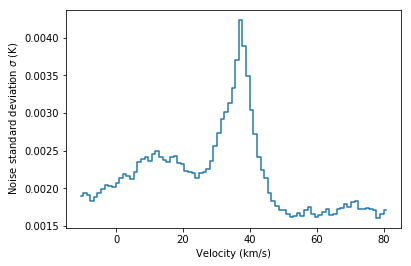

In [16]:
# Make signal mask out of template molecule cube
mad_std_map_sclip = get_noise_map(h2cscube) # Get noise map
plain_mask = h2cssubcube >= 3 * mad_std_map_sclip # Get plain 3sigma mask
plain_masked_slab = h2cssubcube.with_mask(plain_mask) # Mask the template molecule cube
signal_mask = get_signal_mask_scipy(plain_masked_slab, mad_std_map_sclip)

In [13]:
# Get methyl cyanide cube for each K-component
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
freq_spw = '146_spw51'
fn = results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
cube = SpectralCube.read(fn, format='casa_image')
ch3cncube = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', 
                                   rest_value=147.1632441*u.GHz).spectral_slab(-10*u.km/u.s, 
                                                                               80*u.km/u.s)
print(ch3cncube.shape)
ch3cnsubcube = ch3cncube.spectral_slab(-10*u.km/u.s, 30*u.km/u.s)

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/casa_formats_io-0.1-py3.7-linux-x86_64.egg/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


(91, 512, 512)


In [7]:
# Regrid methyl cyanide subcube to match H2CS subcube
ch3cnsubcube_commonbeam = ch3cnsubcube.convolve_to(ch3cnsubcube.beams.common_beam())
ch3cnsubcube_regrid = ch3cnsubcube_commonbeam.spectral_interpolate(h2cssubcube.spectral_axis)
# print(ch3cnsubcube_regrid.spectral_axis - h2cssubcube.spectral_axis)

In [ ]:
# Apply signal mask from template molecule to methyl cyanide K-components
## Also don't forget about continuum subtraction
ch3cnsubcube_regrid.with_mask(signal_mask).write('CH3CN_82-72_masked.fits', overwrite=True)
masked_cube.rechunk()

# subcube_regrid.with_mask(mask, tolerance=1000)
# subcube_regrid.with_mask(mask.include())
# mask.include()
# mask = (h2cscube > 5*u.mJy/u.beam).include().compute()
# subcube_regrid.with_mask(mask)
# #subcube_regrid.with_mask(mask).write('
# get_ipython().run_line_magic('history', '')
# subcube_regrid.with_mask(mask).write('CH3CN_8(0)-7(0)_masked.fits')
# masked_subcube_regrid = subcube_regrid.with_mask(mask)
# masked_subcube_regrid.write('CH3CN_8(0)-7(0)_masked.fits', overwrite=True)
# masked_subcube_regrid
# masked_subcube_regrid.rechunk()
# masked_subcube_regrid.rechunk().write('CH3CN_8(0)-7(0)_masked.fits', overwrite=True)


# ch3cnK0 = SpectralCube.read('./thioformaldehyde/H2CS_303-202.fits')
# ch3cnK0
# ch3cnK0_rg = ch3cnK0.convolve_to(h2cscubes.beams.common_beam()).spectral_interpolate(h2cscube.spectral_axis)
# ch3cnK0_rg.with_mask(mask)
# ch3cnK0 = SpectralCube.read('CH3CN_8(0)-7(0).fits')
# ch3cnK0_rg = ch3cnK0.convolve_to(h2cscubes.beams.common_beam()).spectral_interpolate(h2cscube.spectral_axis)
# h2cscube
# ch3cnK0_rg = ch3cnK0.convolve_to(h2cscube.beams.common_beam()).spectral_interpolate(h2cscube.spectral_axis)
# ch3cnK0_rg
# ch3cnK0_rg.with_mask(mask).write('CH3CN_8(0)-7(0)_masked.fits', overwrite=True)
# #cube = SpectralCube.read('../imaging_results/source_ab_137_spw69_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image')
# ch3cnK0_dask_cube = SpectralCube.read('../imaging_results/source_ab_146_spw51_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image').with_spect
# ral_unit(u.km/u.s, velocity_convention='radio', rest_value=147.1745883*u.GHz)
# ch3cnK0_dask_cube = SpectralCube.read('../imaging_results/source_ab_146_spw51_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image').with_spect
# ral_unit(u.km/u.s, velocity_convention='radio', rest_value=147.1745883*u.GHz)
# ch3cnK0_dc_rg = ch3cnK0_dask_cube.convolve_to(h2cscubes.beams.common_beam()).spectral_interpolate(h2cscube.spectral_axis)
# ch3cnK0_dask_cube = SpectralCube.read('../imaging_results/source_ab_146_spw51_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image').with_spect
# ral_unit(u.km/u.s, velocity_convention='radio', rest_value=147.1745883*u.GHz)
# ch3cnK0_dc_rg = ch3cnK0_dask_cube.convolve_to(h2cscube.beams.common_beam()).spectral_interpolate(h2cscube.spectral_axis)
# # the above is very fast b/c it was lazy
# ch3cnK0_dask_cube = SpectralCube.read('../imaging_results/source_ab_146_spw51_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image').with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=147.1745883*u.GHz).spectral_slab(-10*u.km/u.s, 80*u.km/u.s)
# ch3cnK0_dc_rg = ch3cnK0_dask_cube.convolve_to(h2cscube.beams.common_beam()).spectral_interpolate(h2cscube.spectral_axis)
# # the above is very fast b/c it was lazy
# ch3cnK0_dc_rg
# ch3cnK0_dc_rg._data
# mch3cnK0_dc_rg = ch3cnK0_dc_rg.with_mask(mask)
# with ProgressBar():
#     mch3cnK0_dc_rg.write('TEST.fits')

In [ ]:
masked_cube = SpectralCube.read('CH3CN_82-72_masked.fits')

In [ ]:
# Make moment maps from cube for each individual K-component
masked_moment0 = masked_cube.moment0() # masked_cubes[n]

ax = plt.subplot(projection=masked_moment0.wcs)
im = ax.imshow(masked_moment0.value, origin='lower', cmap='inferno')
cbar = plt.colorbar(im)
cbar.set_label('Integrated Intensity (K km/s)')
ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

In [ ]:
masked_moment1 = masked_cube.moment1() # masked_cubes[n]

ax = plt.subplot(projection=masked_moment1.wcs)
im = ax.imshow(masked_moment1.value, origin='lower', cmap='coolwarm')
cbar = plt.colorbar(im)
cbar.set_label('Centroid (km/s)')

ax.set_ylabel('Declination')
ax.set_xlabel('Right Ascension')

In [ ]:
# use mom0 maps to make temperature map woo!!